# Multi-label Disease Classification of Chest X-Ray Images

UC San Diego Machine Learning Engineering Bootcamp

Tung Nguyen

## Introduction

Dataset: NIH Chest X-Rays from Kaggle, https://www.kaggle.com/nih-chest-xrays/data

This notebook contains a 2nd round of tuning, this time focusing on rescaling, samplewise normalization, and featurewise normalization, which the previous notebook (round 1) did not test.

All models contain:
- VGG16 as the base model
- VGG16's preprocess_input applied in the ImageDataGenerator
- preprocess_input: converts images from RGB to BGR, and zero-centers it with respects to ImageNet dataset, without scaling
- Data augmentation (e.g. randomized flipping, rotation, etc.)

The tests for rescaling, samplewise and featurewise standardization/normalization are done on the best performing model of Round 1 of tuning (weighted loss with no layers frozen).

The descriptions of the models in this notebook are as follows:

6a\. Weighted loss + no blocks frozen, + rescaling by 1./255.

6b\. Weighted loss + no blocks frozen, + samplewise centering 

6c\. Weighted loss + no blocks frozen, + samplewise centering + standardization

6d\. Weighted loss + no blocks frozen, + featurewise centering 

6e\. Weighted loss + no blocks frozen, + featurewise centering + standardization


Models f, g, h, i, j are the same as the 5 above, however, with no preprocess_input applied (these will serve as control tests)

## Imports
---

In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [32]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

In [33]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

## Data Preprocessing
---

### Wrangling

In [34]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Splitting

In [35]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [36]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

### Sampling

In [37]:
plt.style.use('tableau-colorblind10')

In [38]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')
        
    return df_pos

In [39]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

# Normalized class weights for weighted loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 
    
# Non-normalized class weights for weighted loss
pos_2 = np.array([])
neg_2 = np.array([])
for d in weights:
    pos_2 = np.append(pos_2, d[1])
    neg_2 = np.append(neg_2, d[0])

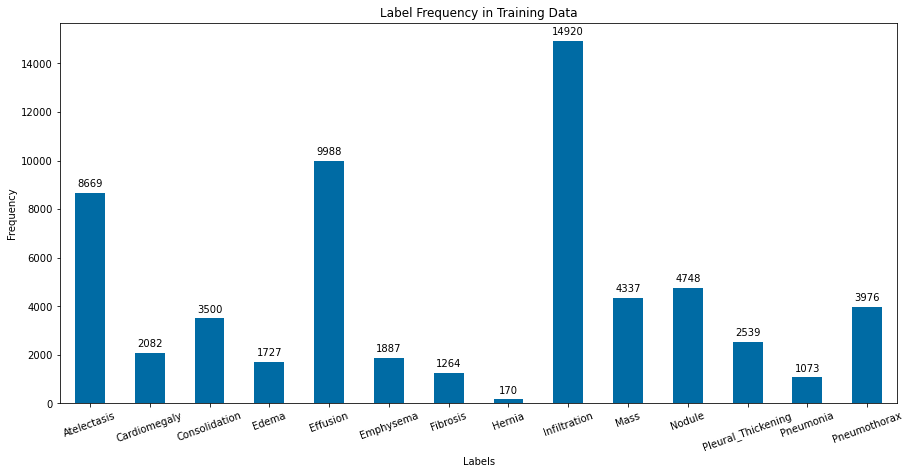

In [40]:
df_freq = plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

Atelectasis           5195.0
Cardiomegaly          1685.0
Consolidation         2751.0
Edema                 1516.0
Effusion              6422.0
Emphysema             1602.0
Fibrosis              1112.0
Hernia                 170.0
Infiltration          6826.0
Mass                  3081.0
Nodule                3063.0
Pleural_Thickening    2059.0
Pneumonia             1015.0
Pneumothorax          2785.0
dtype: float32

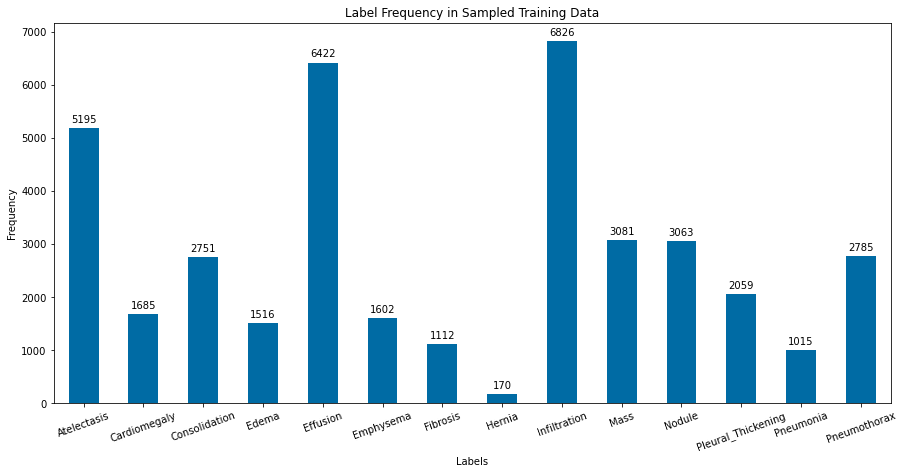

In [41]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])
train_df['sample_weights'] = sample_weights

sampled_train_df = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Sampled Training Data')

Atelectasis           4542.0
Cardiomegaly          2146.0
Consolidation         2756.0
Edema                 2303.0
Effusion              5598.0
Emphysema             2183.0
Fibrosis              1897.0
Hernia                1546.0
Infiltration          6439.0
Mass                  3142.0
Nodule                2918.0
Pleural_Thickening    2555.0
Pneumonia             2017.0
Pneumothorax          2844.0
dtype: float32

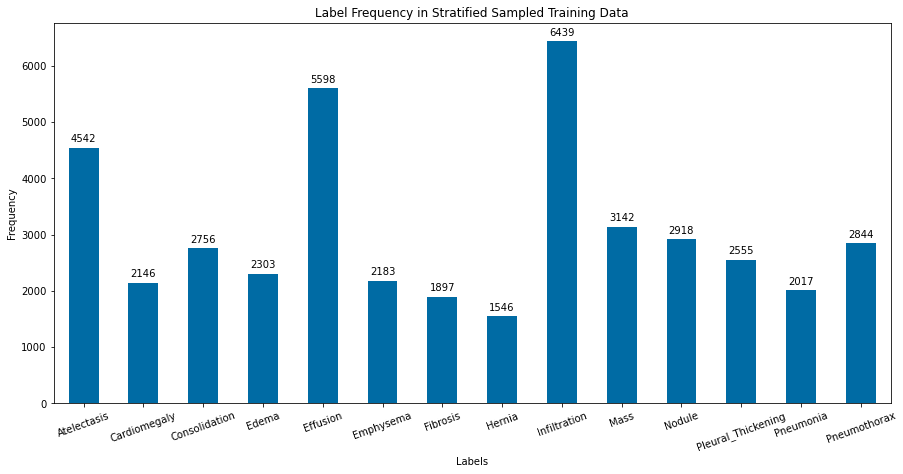

In [42]:
stratified_sampled_train_df = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in labels:
    temp = train_df[train_df[lbl] == 1].sample(
        n,
        replace=True,
        random_state=random_state
    )
    
    stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])
    
# Sample null label
temp = train_df[train_df['Finding Labels'] == ''].sample(
    n,
    replace=False,
    random_state=random_state
)
stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])

plot_df_freq(stratified_sampled_train_df, labels, offset=100, title='Label Frequency in Stratified Sampled Training Data')

In [43]:
def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

### Helper Functions

In [44]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [45]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, preproc_func=None,
                    target_size=(256, 256), val_split=0.2, batch_size=64, sample_size=1000, color_mode='rgb', 
                    sample_center=False, sample_std=False, feature_center=False, feature_std=False, rescale_factor=None, 
                    weight_col=None, random_state=2022):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        samplewise_center=sample_center,
        samplewise_std_normalization=sample_std,
        featurewise_center=feature_center,
        featurewise_std_normalization=feature_std,
        rescale=rescale_factor,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    if feature_center or feature_std:
        raw_train_generator = ImageDataGenerator().flow_from_dataframe(
            train_df,   
            data_path,
            shuffle=True,
            batch_size=sample_size,
            class_mode='raw',
            color_mode=color_mode,
            target_size=target_size,
            x_col=x_col,
            y_col=y_cols,
            seed=random_state
        )

        first_batch = raw_train_generator.next()
        data_sample = first_batch[0]
        datagen.fit(data_sample, augment=False, rounds=1, seed=random_state)

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )
    
    return train_generator, validation_generator, test_generator

In [46]:
# Base Models
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.001
)

## VGG16 Trade Studies
---

### DataGenerators

In [47]:
train_generator_1, valid_generator_1, test_generator_1 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=1./255.
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [48]:
train_generator_2, valid_generator_2, test_generator_2 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=True, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [49]:
train_generator_3, valid_generator_3, test_generator_3 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=True, sample_std=True, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [50]:
train_generator_4, valid_generator_4, test_generator_4 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=True, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 20000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [51]:
train_generator_5, valid_generator_5, test_generator_5 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=True, feature_std=True,
    weight_col=None, rescale_factor=None
)

Found 20000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [52]:
train_generator_6, valid_generator_6, test_generator_6 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=None,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=1./255.
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [53]:
train_generator_7, valid_generator_7, test_generator_7 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=None,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=True, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [54]:
train_generator_8, valid_generator_8, test_generator_8 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=None,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=True, sample_std=True, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [55]:
train_generator_9, valid_generator_9, test_generator_9 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=None,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=True, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 20000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [56]:
train_generator_10, valid_generator_10, test_generator_10 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=None,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=True, feature_std=True,
    weight_col=None, rescale_factor=None
)

Found 20000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


### Model 6a

In [57]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [58]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [59]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6a.h5'

chkpt_1 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [60]:
%%time
history_1 = model.fit(
    train_generator_1, 
    validation_data=valid_generator_1,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_1, early, reduce_lr]
)

Epoch 1/40


2022-01-29 18:52:10.894345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2931

2022-01-29 18:58:21.880227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.52100, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6a.h5
250/250 [==============================] - 436s 2s/step - loss: 1.2931 - val_loss: 1.5210 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2246
Epoch 00002: val_loss did not improve from 1.52100
250/250 [==============================] - 432s 2s/step - loss: 1.2246 - val_loss: 1.5789 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.2146
Epoch 00003: val_loss improved from 1.52100 to 1.49976, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6a.h5
250/250 [==============================] - 431s 2s/step - loss: 1.2146 - val_loss: 1.4998 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.2088
Epoch 00004: val_loss did not improve from 1.49976
250/250 [==============================] - 432s 2s/step - loss: 1.2088 - 

In [61]:
y_pred_1 = model.predict(test_generator_1, batch_size=64, verbose=True)

2022-01-29 20:55:19.501626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 458s 1s/step


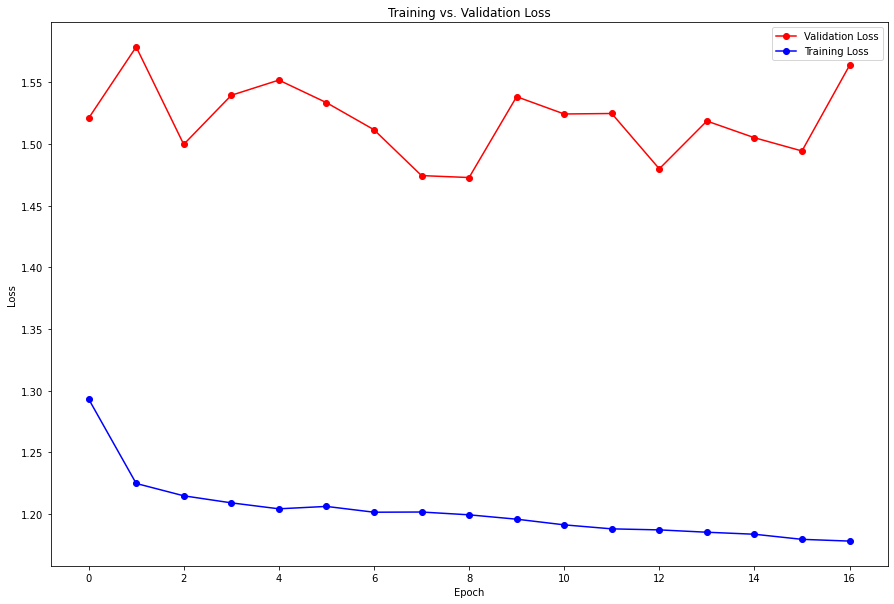

In [62]:
plot_losses(history_1)

AUC = 0.7016 for Atelectasis
AUC = 0.6862 for Cardiomegaly
AUC = 0.7107 for Consolidation
AUC = 0.8121 for Edema
AUC = 0.7344 for Effusion
AUC = 0.5234 for Emphysema
AUC = 0.5898 for Fibrosis
AUC = 0.7246 for Hernia
AUC = 0.6102 for Infiltration
AUC = 0.4822 for Mass
AUC = 0.4953 for Nodule
AUC = 0.5100 for Pleural_Thickening
AUC = 0.4976 for Pneumonia
AUC = 0.5648 for Pneumothorax


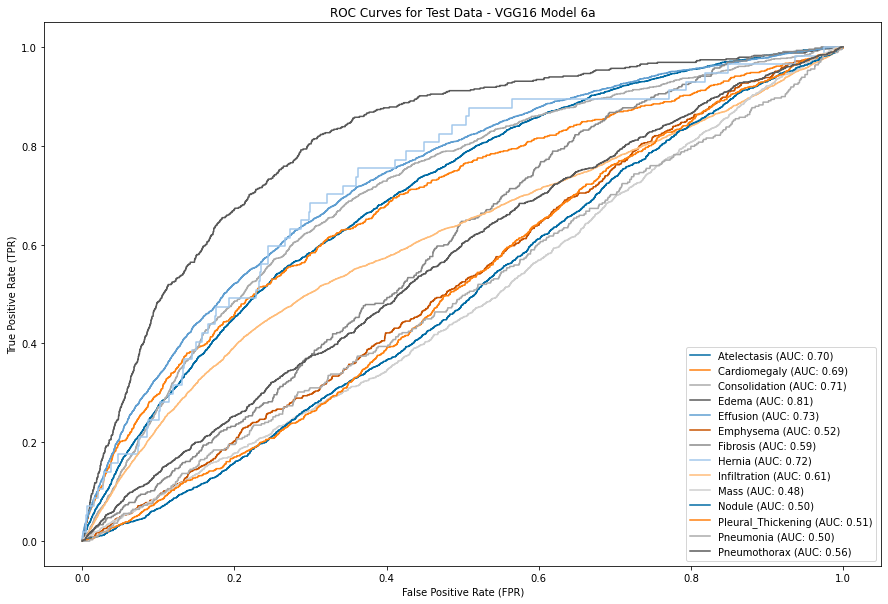

In [63]:
plot_roc_auc(y_pred_1, test_df, labels, model_name='VGG16 Model 6a')

### Model 6b

In [64]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [65]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [66]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6b.h5'

chkpt_2 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [67]:
%%time
history_2 = model.fit(
    train_generator_2, 
    validation_data=valid_generator_2,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_2, early, reduce_lr]
)

Epoch 1/40


2022-01-29 21:02:59.830709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2370

2022-01-29 21:09:13.334826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.53251, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6b.h5
250/250 [==============================] - 438s 2s/step - loss: 1.2370 - val_loss: 1.5325 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1946
Epoch 00002: val_loss improved from 1.53251 to 1.50521, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6b.h5
250/250 [==============================] - 430s 2s/step - loss: 1.1946 - val_loss: 1.5052 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1841
Epoch 00003: val_loss improved from 1.50521 to 1.49744, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6b.h5
250/250 [==============================] - 432s 2s/step - loss: 1.1841 - val_loss: 1.4974 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1790
Epoch 00004: val_loss did not i

In [68]:
y_pred_2 = model.predict(test_generator_2, batch_size=64, verbose=True)

2022-01-30 00:46:45.131534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 447s 1s/step


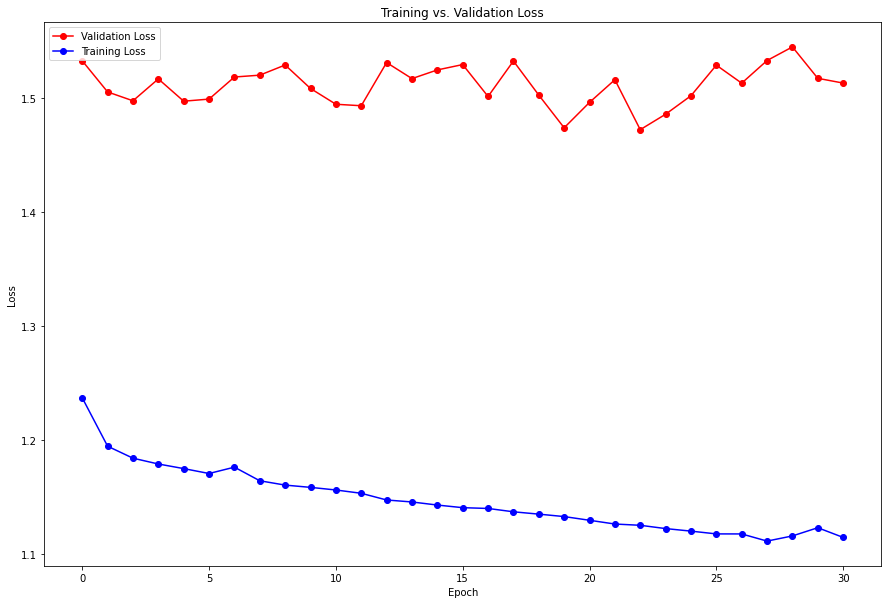

In [69]:
plot_losses(history_2)

AUC = 0.7458 for Atelectasis
AUC = 0.8380 for Cardiomegaly
AUC = 0.7351 for Consolidation
AUC = 0.8420 for Edema
AUC = 0.8084 for Effusion
AUC = 0.6333 for Emphysema
AUC = 0.6151 for Fibrosis
AUC = 0.6544 for Hernia
AUC = 0.6469 for Infiltration
AUC = 0.5784 for Mass
AUC = 0.5330 for Nodule
AUC = 0.6033 for Pleural_Thickening
AUC = 0.4682 for Pneumonia
AUC = 0.6896 for Pneumothorax


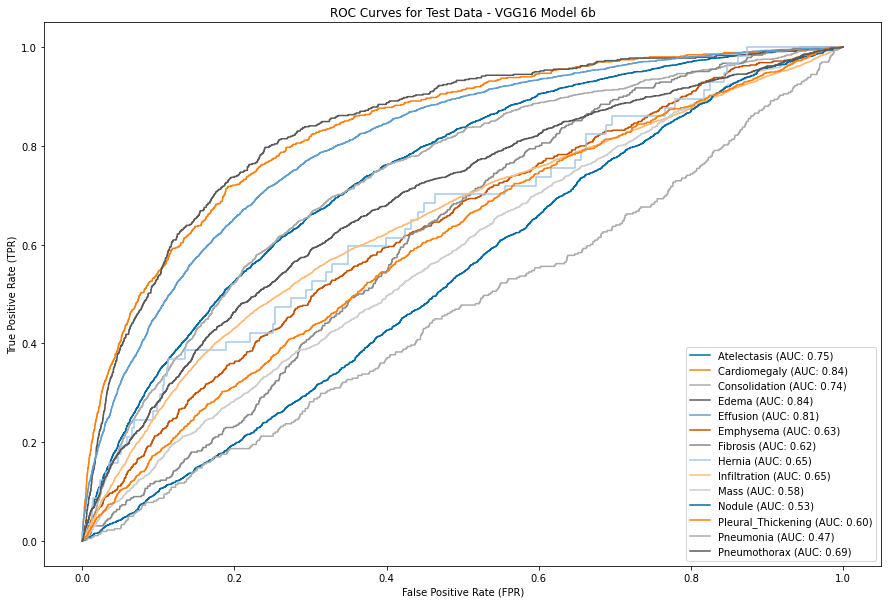

In [70]:
plot_roc_auc(y_pred_2, test_df, labels, model_name='VGG16 Model 6b')

### Model 6c

In [71]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [72]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [73]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6c.h5'

chkpt_3 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [74]:
%%time
history_3 = model.fit(
    train_generator_3, 
    validation_data=valid_generator_3,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_3, early, reduce_lr]
)

Epoch 1/40


2022-01-30 00:54:14.244544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2412

2022-01-30 01:00:19.467216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.59665, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6c.h5
250/250 [==============================] - 431s 2s/step - loss: 1.2412 - val_loss: 1.5966 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2383
Epoch 00002: val_loss improved from 1.59665 to 1.56330, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6c.h5
250/250 [==============================] - 429s 2s/step - loss: 1.2383 - val_loss: 1.5633 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.2379
Epoch 00003: val_loss improved from 1.56330 to 1.54334, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6c.h5
250/250 [==============================] - 429s 2s/step - loss: 1.2379 - val_loss: 1.5433 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.2381
Epoch 00004: val_loss did not i

In [75]:
y_pred_3 = model.predict(test_generator_3, batch_size=64, verbose=True)

2022-01-30 03:17:44.996834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 457s 1s/step


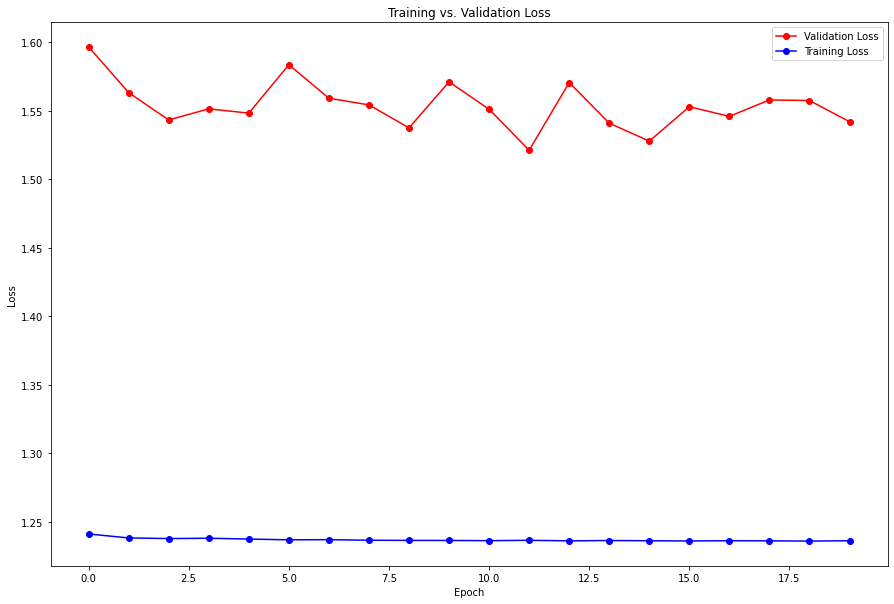

In [76]:
plot_losses(history_3)

AUC = 0.5000 for Atelectasis
AUC = 0.5000 for Cardiomegaly
AUC = 0.5000 for Consolidation
AUC = 0.5000 for Edema
AUC = 0.5000 for Effusion
AUC = 0.5000 for Emphysema
AUC = 0.5000 for Fibrosis
AUC = 0.5000 for Hernia
AUC = 0.5000 for Infiltration
AUC = 0.5000 for Mass
AUC = 0.5000 for Nodule
AUC = 0.5000 for Pleural_Thickening
AUC = 0.5000 for Pneumonia
AUC = 0.5000 for Pneumothorax


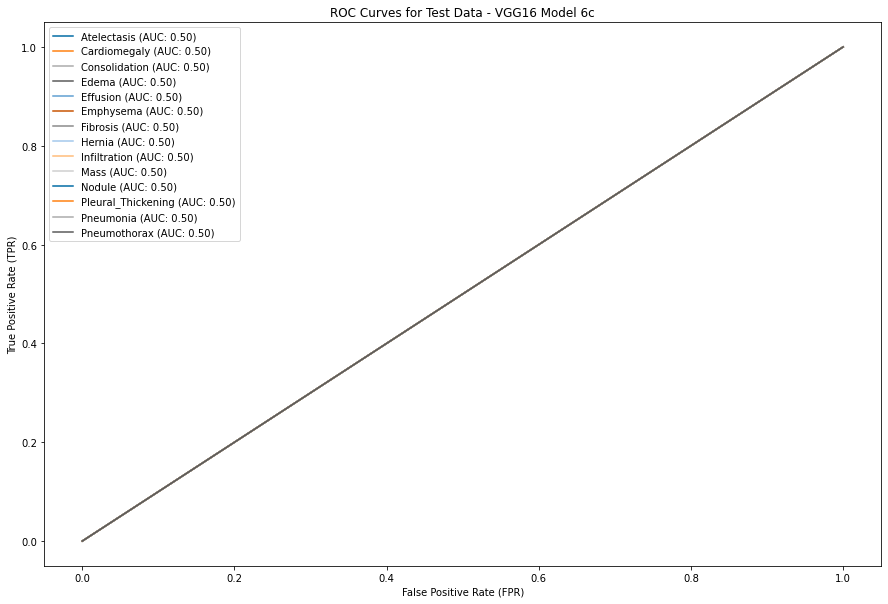

In [77]:
plot_roc_auc(y_pred_3, test_df, labels, model_name='VGG16 Model 6c')

### Model 6d

In [78]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [79]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [80]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6d.h5'

chkpt_4 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [81]:
%%time
history_4 = model.fit(
    train_generator_4, 
    validation_data=valid_generator_4,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_4, early, reduce_lr]
)

Epoch 1/40


2022-01-30 03:25:23.947008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2384

2022-01-30 03:31:29.014719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.52319, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6d.h5
250/250 [==============================] - 429s 2s/step - loss: 1.2384 - val_loss: 1.5232 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2153
Epoch 00002: val_loss improved from 1.52319 to 1.51393, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6d.h5
250/250 [==============================] - 428s 2s/step - loss: 1.2153 - val_loss: 1.5139 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.2086
Epoch 00003: val_loss improved from 1.51393 to 1.50803, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6d.h5
250/250 [==============================] - 428s 2s/step - loss: 1.2086 - val_loss: 1.5080 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.2066
Epoch 00004: val_loss did not i

In [82]:
y_pred_4 = model.predict(test_generator_4, batch_size=64, verbose=True)

2022-01-30 05:19:44.882986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 444s 1s/step


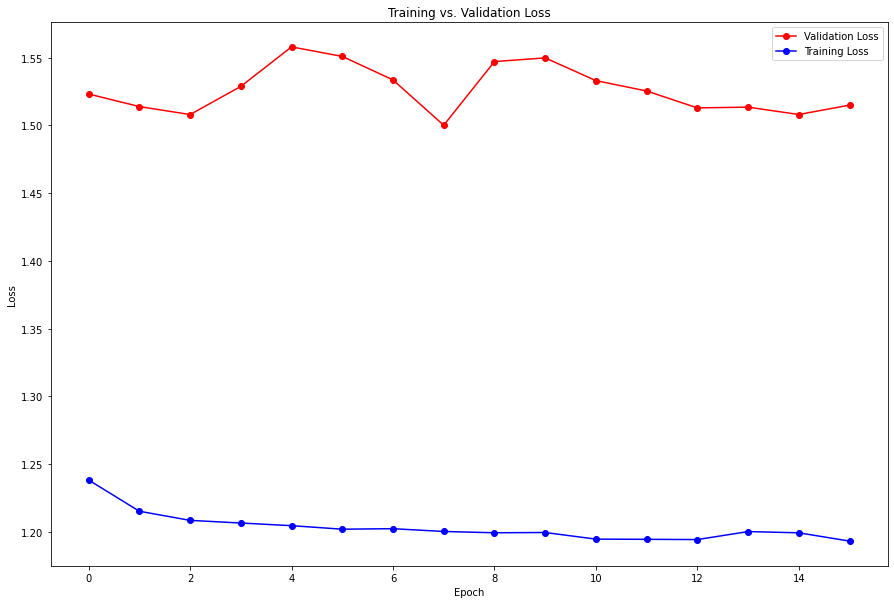

In [83]:
plot_losses(history_4)

AUC = 0.6392 for Atelectasis
AUC = 0.5828 for Cardiomegaly
AUC = 0.6919 for Consolidation
AUC = 0.7812 for Edema
AUC = 0.6601 for Effusion
AUC = 0.5272 for Emphysema
AUC = 0.6384 for Fibrosis
AUC = 0.6509 for Hernia
AUC = 0.6146 for Infiltration
AUC = 0.5253 for Mass
AUC = 0.5469 for Nodule
AUC = 0.5610 for Pleural_Thickening
AUC = 0.5069 for Pneumonia
AUC = 0.5510 for Pneumothorax


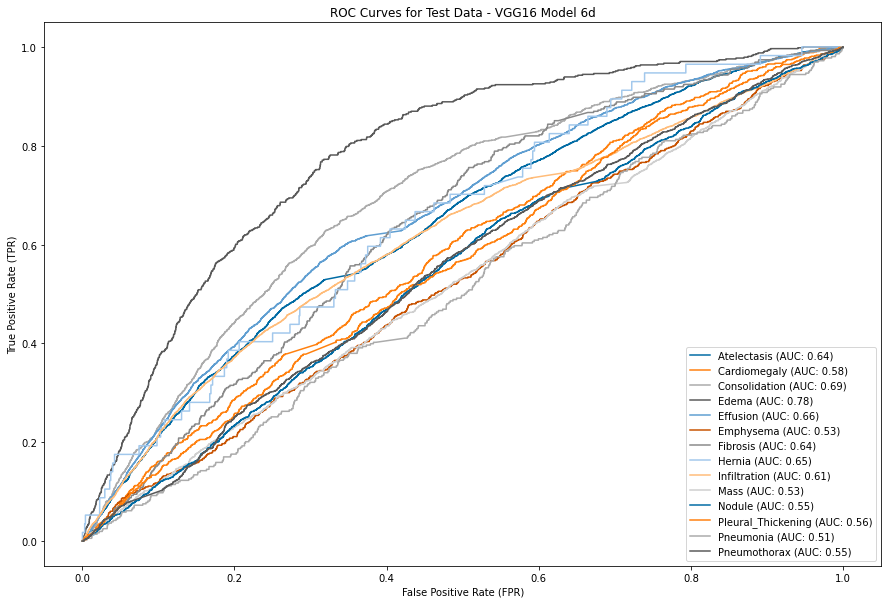

In [84]:
plot_roc_auc(y_pred_4, test_df, labels, model_name='VGG16 Model 6d')

### Model 6e

In [85]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [86]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [87]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6e.h5'

chkpt_5 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [88]:
%%time
history_5 = model.fit(
    train_generator_5, 
    validation_data=valid_generator_5,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_5, early, reduce_lr]
)

Epoch 1/40


2022-01-30 05:27:10.740176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2170

2022-01-30 05:33:15.909693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.55559, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6e.h5
250/250 [==============================] - 430s 2s/step - loss: 1.2170 - val_loss: 1.5556 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1960
Epoch 00002: val_loss did not improve from 1.55559
250/250 [==============================] - 428s 2s/step - loss: 1.1960 - val_loss: 1.5766 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1921
Epoch 00003: val_loss did not improve from 1.55559
250/250 [==============================] - 428s 2s/step - loss: 1.1921 - val_loss: 1.5716 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1910
Epoch 00004: val_loss improved from 1.55559 to 1.50681, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6e.h5
250/250 [==============================] - 428s 2s/step - loss: 1.1910 - 

In [89]:
y_pred_5 = model.predict(test_generator_5, batch_size=64, verbose=True)

2022-01-30 08:25:44.987010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 453s 1s/step


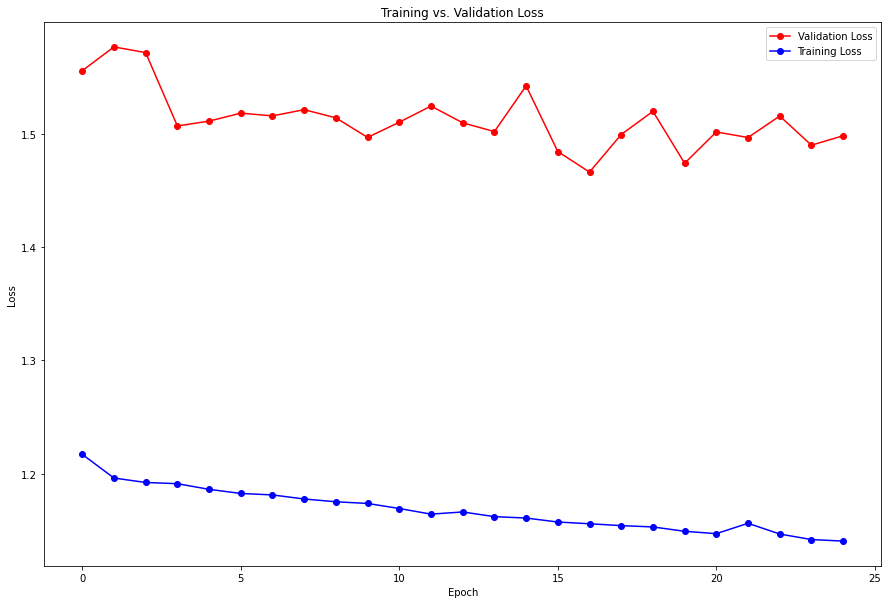

In [90]:
plot_losses(history_5)

AUC = 0.7180 for Atelectasis
AUC = 0.7803 for Cardiomegaly
AUC = 0.7196 for Consolidation
AUC = 0.8253 for Edema
AUC = 0.7831 for Effusion
AUC = 0.5829 for Emphysema
AUC = 0.6257 for Fibrosis
AUC = 0.7400 for Hernia
AUC = 0.6395 for Infiltration
AUC = 0.5806 for Mass
AUC = 0.5485 for Nodule
AUC = 0.6015 for Pleural_Thickening
AUC = 0.4595 for Pneumonia
AUC = 0.6654 for Pneumothorax


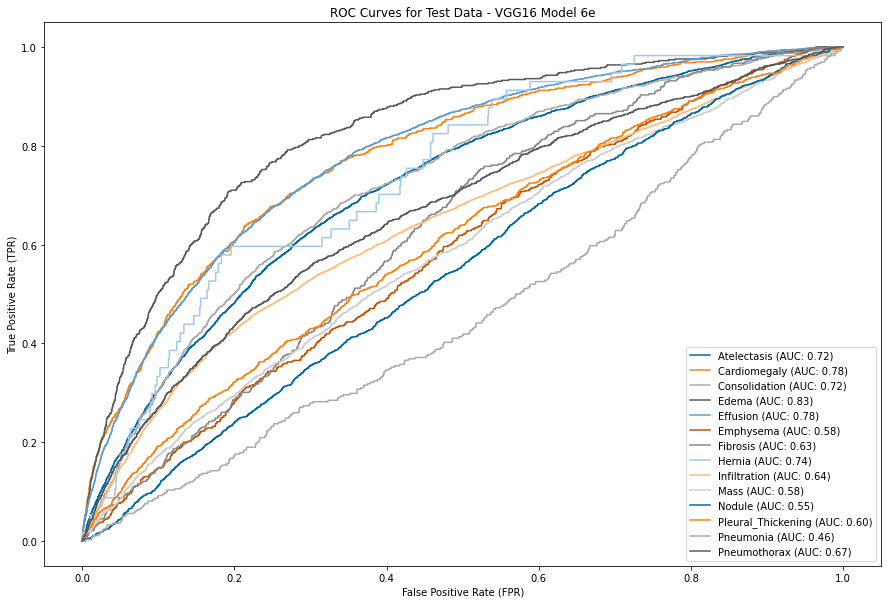

In [91]:
plot_roc_auc(y_pred_5, test_df, labels, model_name='VGG16 Model 6e')

### Model 6f (no preprocess_input)

In [92]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [93]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [94]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6f.h5'

chkpt_6 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [95]:
%%time
history_6 = model.fit(
    train_generator_6, 
    validation_data=valid_generator_6,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_6, early, reduce_lr]
)

Epoch 1/40


2022-01-30 08:33:20.608494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2404

2022-01-30 08:39:27.217696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.56099, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6f.h5
250/250 [==============================] - 431s 2s/step - loss: 1.2404 - val_loss: 1.5610 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2167
Epoch 00002: val_loss improved from 1.56099 to 1.52148, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6f.h5
250/250 [==============================] - 430s 2s/step - loss: 1.2167 - val_loss: 1.5215 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1890
Epoch 00003: val_loss improved from 1.52148 to 1.51864, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6f.h5
250/250 [==============================] - 429s 2s/step - loss: 1.1890 - val_loss: 1.5186 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1688
Epoch 00004: val_loss improved 

In [96]:
y_pred_6 = model.predict(test_generator_6, batch_size=64, verbose=True)

2022-01-30 11:03:45.266901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 439s 1s/step


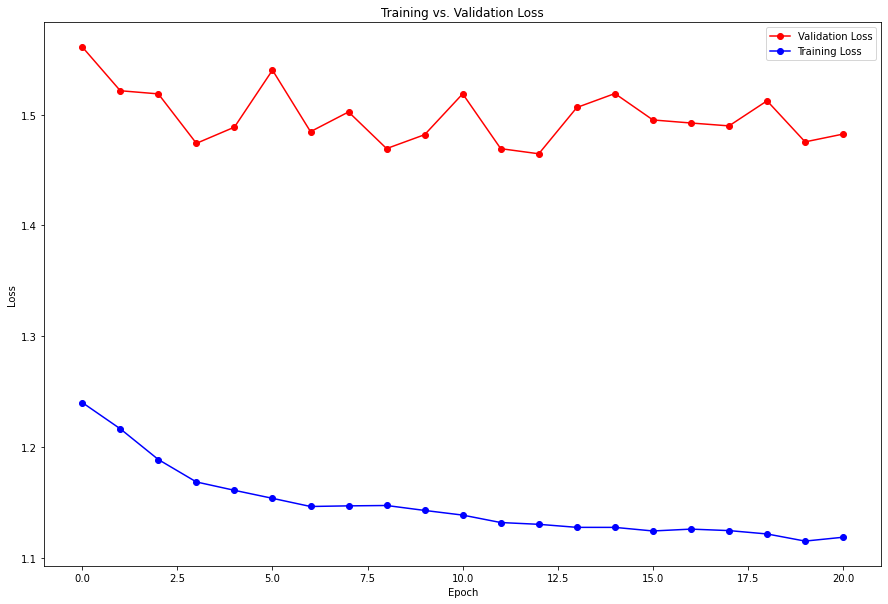

In [97]:
plot_losses(history_6)

AUC = 0.7286 for Atelectasis
AUC = 0.8400 for Cardiomegaly
AUC = 0.7264 for Consolidation
AUC = 0.8386 for Edema
AUC = 0.8045 for Effusion
AUC = 0.6551 for Emphysema
AUC = 0.6301 for Fibrosis
AUC = 0.7045 for Hernia
AUC = 0.6449 for Infiltration
AUC = 0.6000 for Mass
AUC = 0.5523 for Nodule
AUC = 0.6112 for Pleural_Thickening
AUC = 0.4618 for Pneumonia
AUC = 0.7109 for Pneumothorax


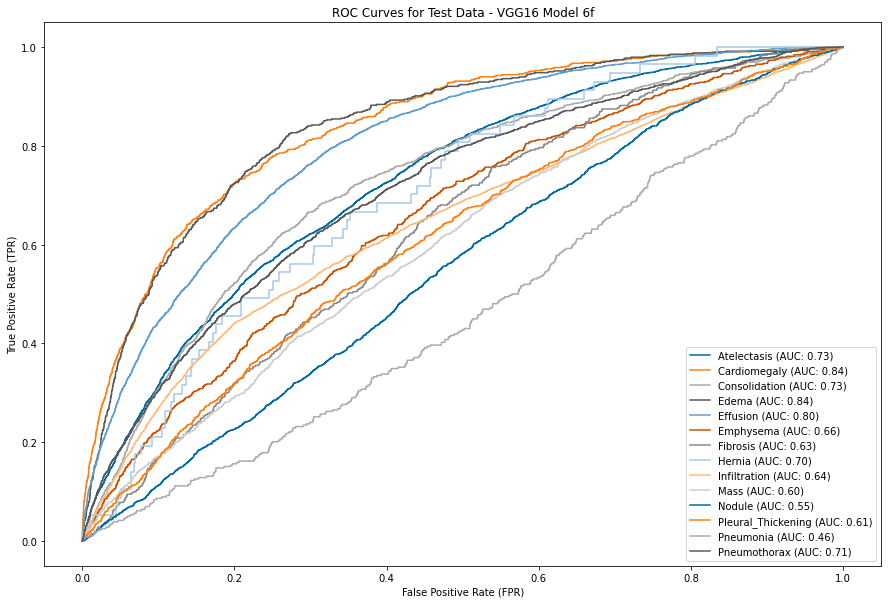

In [98]:
plot_roc_auc(y_pred_6, test_df, labels, model_name='VGG16 Model 6f')

### Model 6g (no preprocess_input)

In [99]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [100]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [101]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6g.h5'

chkpt_7 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [102]:
%%time
history_7 = model.fit(
    train_generator_7, 
    validation_data=valid_generator_7,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_7, early, reduce_lr]
)

Epoch 1/40


2022-01-30 11:11:06.562758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2482

2022-01-30 11:17:11.955639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.52898, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6g.h5
250/250 [==============================] - 430s 2s/step - loss: 1.2482 - val_loss: 1.5290 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1979
Epoch 00002: val_loss did not improve from 1.52898
250/250 [==============================] - 428s 2s/step - loss: 1.1979 - val_loss: 1.5810 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1907
Epoch 00003: val_loss did not improve from 1.52898
250/250 [==============================] - 430s 2s/step - loss: 1.1907 - val_loss: 1.5327 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1813
Epoch 00004: val_loss did not improve from 1.52898
250/250 [==============================] - 429s 2s/step - loss: 1.1813 - val_loss: 1.5305 - lr: 0.0010
Epoch 5/40
250/250 [==============================] - ETA: 0s -

In [103]:
y_pred_7 = model.predict(test_generator_7, batch_size=64, verbose=True)

2022-01-30 12:51:18.295026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 455s 1s/step


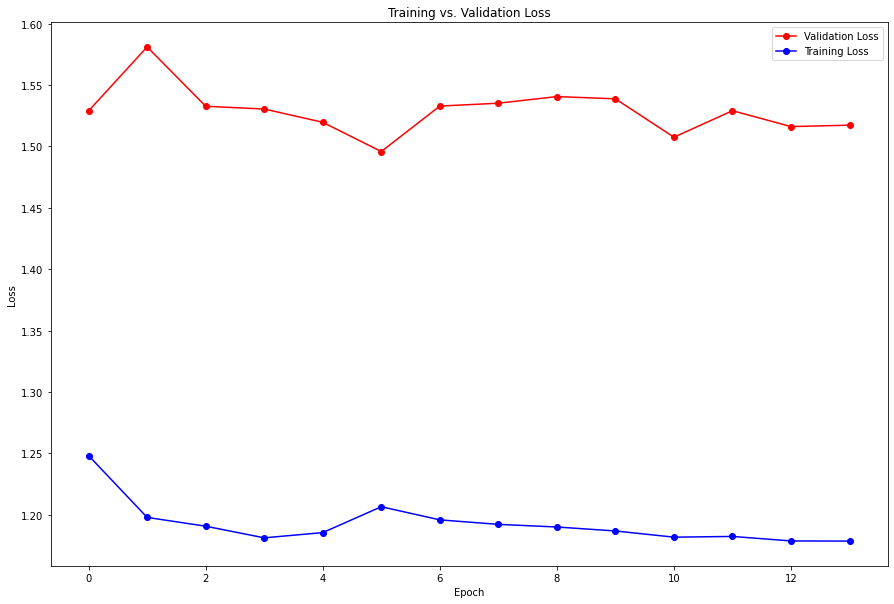

In [104]:
plot_losses(history_7)

AUC = 0.6930 for Atelectasis
AUC = 0.7520 for Cardiomegaly
AUC = 0.7168 for Consolidation
AUC = 0.8011 for Edema
AUC = 0.7463 for Effusion
AUC = 0.5195 for Emphysema
AUC = 0.5887 for Fibrosis
AUC = 0.6443 for Hernia
AUC = 0.6423 for Infiltration
AUC = 0.5147 for Mass
AUC = 0.5192 for Nodule
AUC = 0.5507 for Pleural_Thickening
AUC = 0.4284 for Pneumonia
AUC = 0.6196 for Pneumothorax


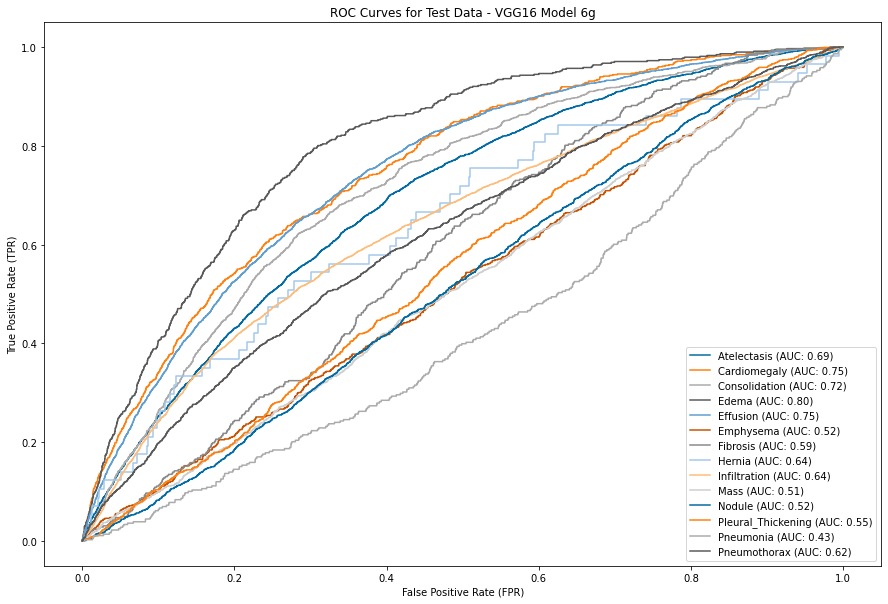

In [105]:
plot_roc_auc(y_pred_7, test_df, labels, model_name='VGG16 Model 6g')

### Model 6h (no preprocess_input)

In [106]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [107]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [108]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6h.h5'

chkpt_8 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [109]:
%%time
history_8 = model.fit(
    train_generator_8, 
    validation_data=valid_generator_8,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_8, early, reduce_lr]
)

Epoch 1/40


2022-01-30 12:58:55.870319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2022

2022-01-30 13:05:08.066075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.49472, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6h.h5
250/250 [==============================] - 440s 2s/step - loss: 1.2022 - val_loss: 1.4947 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1796
Epoch 00002: val_loss improved from 1.49472 to 1.45601, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6h.h5
250/250 [==============================] - 436s 2s/step - loss: 1.1796 - val_loss: 1.4560 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1728
Epoch 00003: val_loss did not improve from 1.45601
250/250 [==============================] - 434s 2s/step - loss: 1.1728 - val_loss: 1.5261 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1694
Epoch 00004: val_loss did not improve from 1.45601
250/250 [==============================] - 435s 2s/step - loss: 1.1694 - 

In [110]:
y_pred_8 = model.predict(test_generator_8, batch_size=64, verbose=True)

2022-01-30 14:11:21.035684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 472s 1s/step


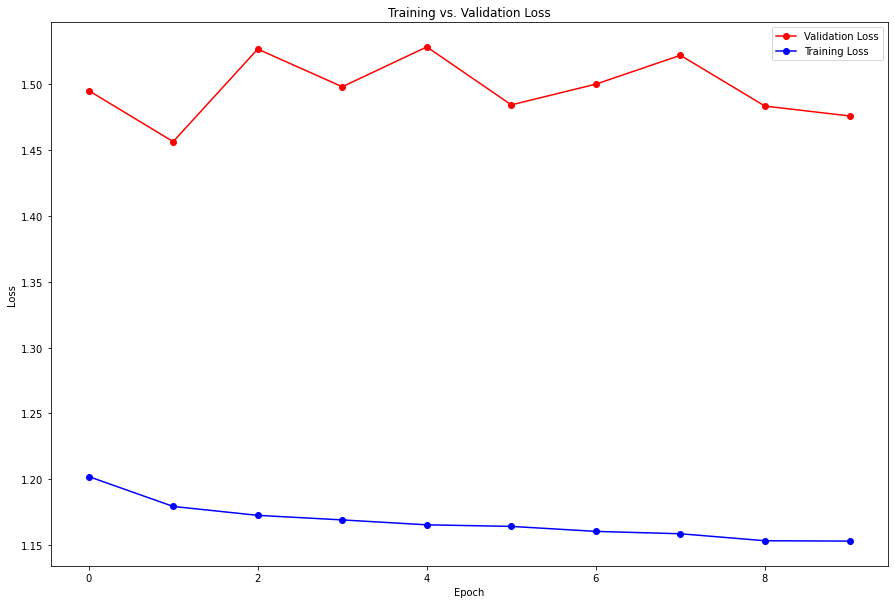

In [111]:
plot_losses(history_8)

AUC = 0.7135 for Atelectasis
AUC = 0.8084 for Cardiomegaly
AUC = 0.7297 for Consolidation
AUC = 0.8301 for Edema
AUC = 0.7800 for Effusion
AUC = 0.5673 for Emphysema
AUC = 0.6150 for Fibrosis
AUC = 0.6749 for Hernia
AUC = 0.6529 for Infiltration
AUC = 0.5713 for Mass
AUC = 0.5160 for Nodule
AUC = 0.5820 for Pleural_Thickening
AUC = 0.5355 for Pneumonia
AUC = 0.6659 for Pneumothorax


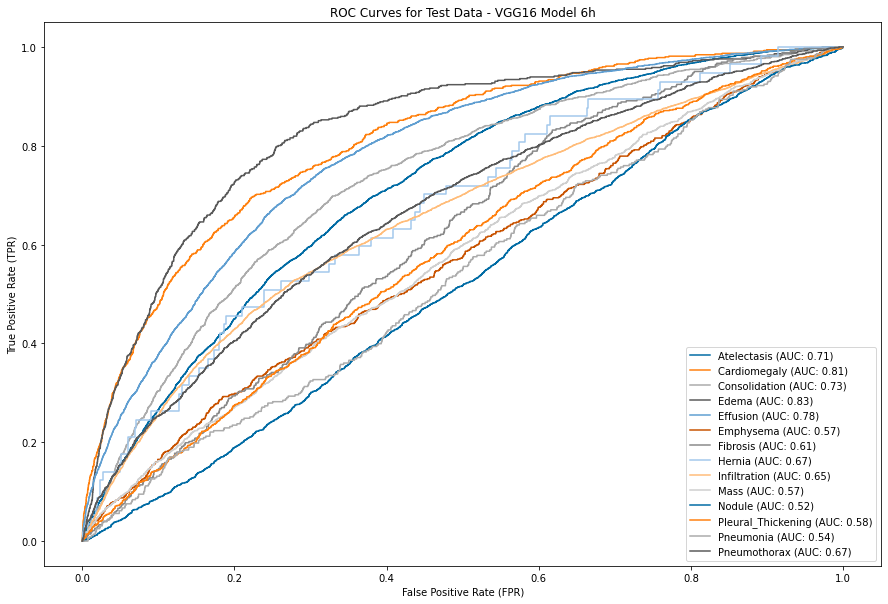

In [112]:
plot_roc_auc(y_pred_8, test_df, labels, model_name='VGG16 Model 6h')

### Model 6i (no preprocess_input)

In [113]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [114]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [115]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6i.h5'

chkpt_9 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [116]:
%%time
history_9 = model.fit(
    train_generator_9, 
    validation_data=valid_generator_9,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_9, early, reduce_lr]
)

Epoch 1/40


2022-01-30 14:19:15.201619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2307

2022-01-30 14:25:25.671689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.53444, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6i.h5
250/250 [==============================] - 434s 2s/step - loss: 1.2307 - val_loss: 1.5344 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2122
Epoch 00002: val_loss did not improve from 1.53444
250/250 [==============================] - 428s 2s/step - loss: 1.2122 - val_loss: 1.5361 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.2067
Epoch 00003: val_loss improved from 1.53444 to 1.53032, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6i.h5
250/250 [==============================] - 429s 2s/step - loss: 1.2067 - val_loss: 1.5303 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.2044
Epoch 00004: val_loss did not improve from 1.53032
250/250 [==============================] - 428s 2s/step - loss: 1.2044 - 

In [117]:
y_pred_9 = model.predict(test_generator_9, batch_size=64, verbose=True)

2022-01-30 15:52:45.747431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 440s 1s/step


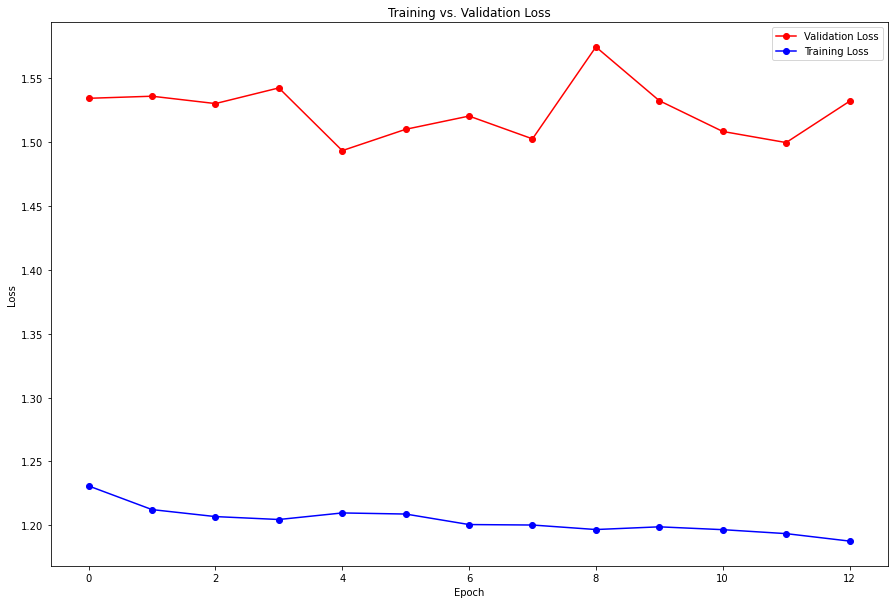

In [118]:
plot_losses(history_9)

AUC = 0.6770 for Atelectasis
AUC = 0.6672 for Cardiomegaly
AUC = 0.7196 for Consolidation
AUC = 0.8215 for Edema
AUC = 0.7189 for Effusion
AUC = 0.5081 for Emphysema
AUC = 0.5711 for Fibrosis
AUC = 0.6179 for Hernia
AUC = 0.6440 for Infiltration
AUC = 0.4995 for Mass
AUC = 0.5238 for Nodule
AUC = 0.5095 for Pleural_Thickening
AUC = 0.4561 for Pneumonia
AUC = 0.5803 for Pneumothorax


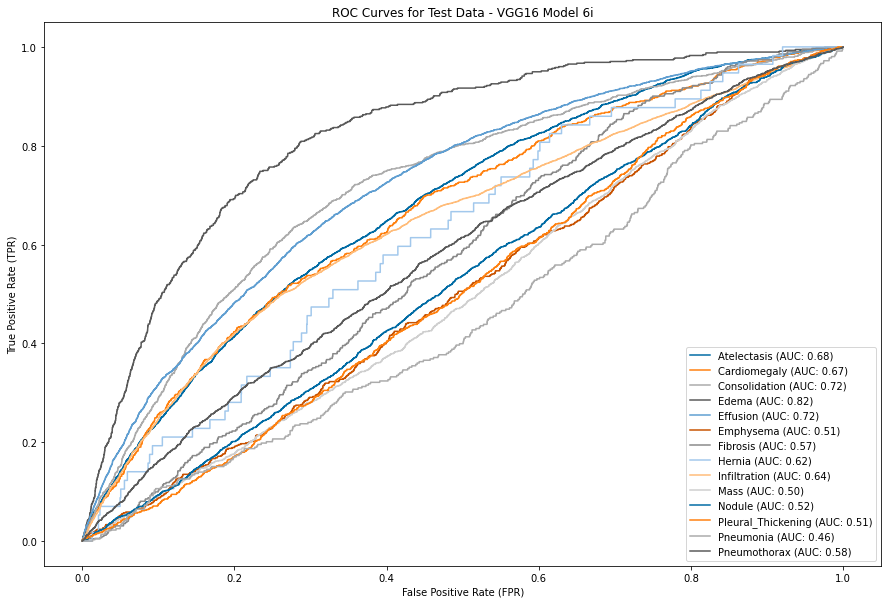

In [119]:
plot_roc_auc(y_pred_9, test_df, labels, model_name='VGG16 Model 6i')

### Model 6j (no preprocess_input)

In [120]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True

model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)     

In [121]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [122]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6j.h5'

chkpt_10 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [123]:
%%time
history_10 = model.fit(
    train_generator_10, 
    validation_data=valid_generator_10,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_10, early, reduce_lr]
)

Epoch 1/40


2022-01-30 16:00:07.900414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2125

2022-01-30 16:06:12.968452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.54456, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6j.h5
250/250 [==============================] - 429s 2s/step - loss: 1.2125 - val_loss: 1.5446 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1841
Epoch 00002: val_loss improved from 1.54456 to 1.49767, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6j.h5
250/250 [==============================] - 427s 2s/step - loss: 1.1841 - val_loss: 1.4977 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1744
Epoch 00003: val_loss did not improve from 1.49767
250/250 [==============================] - 427s 2s/step - loss: 1.1744 - val_loss: 1.5274 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1676
Epoch 00004: val_loss improved from 1.49767 to 1.47610, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round

In [124]:
y_pred_10 = model.predict(test_generator_10, batch_size=64, verbose=True)

2022-01-30 17:40:05.239577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 450s 1s/step


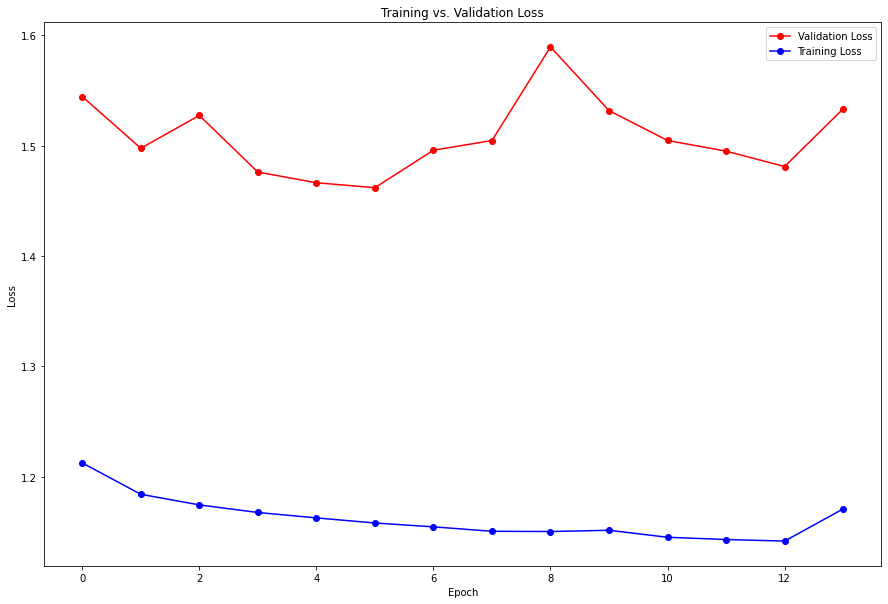

In [125]:
plot_losses(history_10)

AUC = 0.6999 for Atelectasis
AUC = 0.7238 for Cardiomegaly
AUC = 0.7150 for Consolidation
AUC = 0.7997 for Edema
AUC = 0.7483 for Effusion
AUC = 0.5732 for Emphysema
AUC = 0.6035 for Fibrosis
AUC = 0.6521 for Hernia
AUC = 0.6268 for Infiltration
AUC = 0.5761 for Mass
AUC = 0.5139 for Nodule
AUC = 0.5552 for Pleural_Thickening
AUC = 0.4605 for Pneumonia
AUC = 0.6303 for Pneumothorax


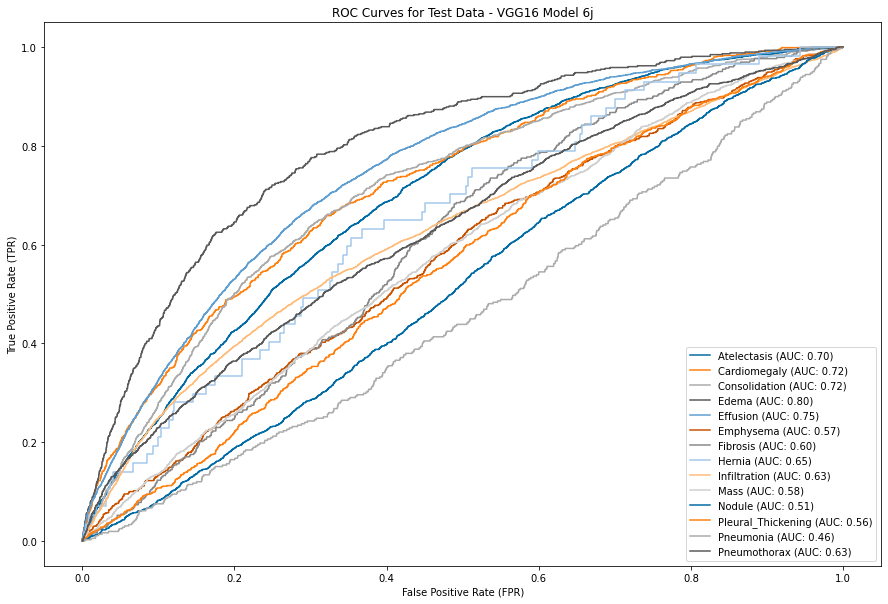

In [126]:
plot_roc_auc(y_pred_10, test_df, labels, model_name='VGG16 Model 6j')